## CLIP Encoder

**The encoder transforms all input sequences (e.g. the raw text user prompt) into embeddings.** 

Embeddings are vectors that represent the semantic "meaning" of each word in the text (ex. the words "blue" and "ocean" have vectors closer in value than the words "cat" and "saturn").

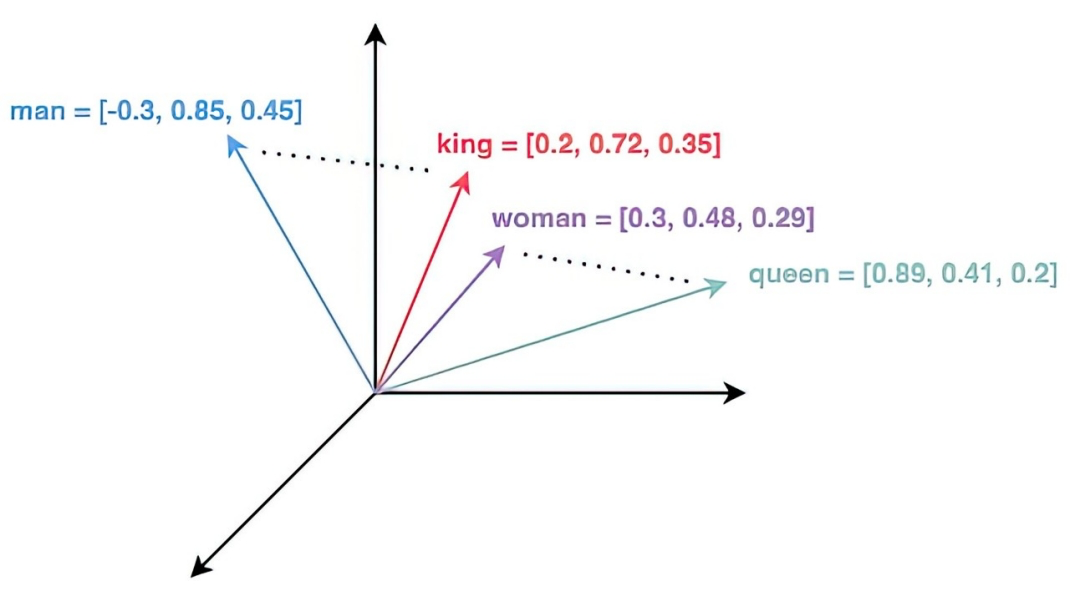

In [268]:
from IPython.display import Image, display
display(Image(filename='../../assets/Diffusion/4-emb.png', width=500, height=500))

The CLIP encoder is trained to embed images and text into the **same latent space**, so semantically similar images and text are close together in this space.

Here, we will discuss the text encoder. The text encoder is a Transformer. For computational efficiency and maximal understanding, we will restrict the model base size and max sequence length.

The encoder takes the raw user prompt as input, and outputs:


 - **Sequence embeddings**: one embedding vector per token in the prompt, used for token-level attention in the transformer so each word can be attended to.
 - **Pooled embedding**: a single embedding vector representing the entire prompt, used for time conditioning.

### Architecture overview:

The CLIP text encoder architecture consists of:
<br><br>

1. [**Tokenization**](#1-tokenization)
    <br><br>
    **input**: raw user input
- tokenize with BPE tokenizer
- preprend with [SOS] tokens 
    - SOS: "start of sequence"
    - The embedding at the **first** token position
    - Used for the **pooled embedding**
- truncate to fixed length (77 tokens)
    <br>

    **output**: list of tokens
    ex. user prompt: `"a red cat"` -> `["a", "red", "cat"]`

<br>

2. [**Embedding layer**](#2-embedding-layer)
    <br><br>
    **input:** list of tokens
- each token is mapped to a lookup embedding (pretrained embeddings). i.e. each token is assigned their corresponding embedding in a "generic"/static/already-trained embedding space
<br>
ex. `["a red cat"] -> [0.1, 0.8, 0.5]`
- add positional embeddings
    - since transformers don't know the order of tokens

    **output**: static embeddings of user input's tokens with positional info/conditioning

    <br>

3. [**Transformer**](#3-transformer)
    <br><br>
    **input**: sum of token embeddings and positional embeddings (static embeddings of user input's tokens with token position info/conditioning)
- multi-head self-attention layer. for each head,
    - **computes queries (Q), keys (K) & values (V)**
    - compute attention scores
    - multiply scores by values
    - concatenate all heads & apply final linear transformation
- the attention output is added to the original input (residual connection)
    - then passed through a layer norm
- each token vector is passed through the same 2-layer MLP
- apply another residual + layer norm
    

    **output**: sequence embeddings and pooled embedding

    for more info on the transformer, see <a href="../../transformer/transformer_notes.ipynb">transformer notes</a>
    

### 1. Tokenization

We import & intialize the BPE tokenizer from HuggingFace

In [269]:
# Install required dependencies (run this if you get import errors)
# !pip install transformers torch

In [270]:
from transformers import CLIPTokenizerFast, CLIPTextModel

embedding_dim = 512
class CLIPTextCheckpoints:
    def __init__(self, embedding_dim=embedding_dim):
        self._tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-large-patch14")

    def encode(self, text):
        return self._tokenizer(text, return_tensors="pt").input_ids

pretrained = CLIPTextCheckpoints()

In [271]:
prompt = "a red cat"
print(f"Prompt: '{prompt}'")

token_ids = pretrained.encode(prompt)

# print(f"Token IDs shape: {token_ids.shape}")    # [batch size (# of sequences being processed at once), max sequence length (# of tokens in each sequence)]
print(f"Token IDs: {token_ids[0][:10].tolist()}")
print(f"Number of tokens: {token_ids.shape[1]}")

# decode back to tokens to see what the tokenizer did (prepend <|startoftext|> and append <|endoftext|>)
tokens = pretrained._tokenizer.convert_ids_to_tokens(token_ids[0])
print(f"Tokens: {tokens[:10]}...")

Prompt: 'a red cat'
Token IDs: [49406, 320, 736, 2368, 49407]
Number of tokens: 5
Tokens: ['<|startoftext|>', 'a</w>', 'red</w>', 'cat</w>', '<|endoftext|>']...


While there are 3 words in the prompt ("a", "red", & "cat"), the tokenizer adds <|startoftext|> & <|endoftext|> tokens, resulting in 5 total tokens.

### 2. Embedding Layer

In [272]:
import torch
import torch.nn as nn

num_embeddings = pretrained._tokenizer.vocab_size
embedding_dim = 512

embedding_layer = torch.nn.Embedding(num_embeddings, embedding_dim)
print(f"Embedding layer: {embedding_layer}")

# positional embedding: order/position of tokens in the sequence (conditioning for the transformer)
max_length = 77
positional_embedding = nn.Parameter(torch.empty(max_length, embedding_dim))
nn.init.normal_(positional_embedding, std=0.01)  # or use truncated normal

# use the token IDs from our prompt "a red cat"
input_ids = token_ids  # shape: [1, 5] - already tokenized above

# (1) token embeddings
token_embeddings = embedding_layer(input_ids)  # (batch, seq_len, dim)

# (2) add positional embeddings (only use the length we need)
seq_len = input_ids.shape[1]  # 5 tokens
positioned = token_embeddings + positional_embedding[:seq_len].unsqueeze(0)  # (batch, seq_len, dim)

if token_ids.shape[1] > max_length:
    token_ids = token_ids[:, :max_length]
else:
    padding_length = max_length - token_ids.shape[1]
    token_ids = torch.cat([token_ids, torch.zeros(1, padding_length, dtype=token_ids.dtype)], dim=1)

print(f"Token embeddings shape: {token_embeddings.shape}")
print(f"Positional embeddings used: {positional_embedding[:seq_len].shape}")
print(f"Final positioned embeddings shape: {positioned.shape}")

Embedding layer: Embedding(49408, 512)
Token embeddings shape: torch.Size([1, 5, 512])
Positional embeddings used: torch.Size([5, 512])
Final positioned embeddings shape: torch.Size([1, 5, 512])


Now we have the "generic"/static embeddings of the tokens of the user's input! Let's move on to the Transformer.

### 3. Transformer

In [273]:
import math
    
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, n_heads=8):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_heads = n_heads
        self.head_dim = embedding_dim // n_heads

        assert self.head_dim * n_heads == embedding_dim, "embedding dimension must be divisible by number of heads"

        # linear projections for queries, keys, and values
        self.W_q = nn.Linear(embedding_dim, embedding_dim)
        self.W_k = nn.Linear(embedding_dim, embedding_dim)
        self.W_v = nn.Linear(embedding_dim, embedding_dim)

        # final linear projection
        self.W_o = nn.Linear(embedding_dim, embedding_dim)
        
    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # linear projections
        q = self.W_q(x) # (batch_size, seq_len, embedding_dim)
        k = self.W_k(x) # (batch_size, seq_len, embedding_dim)
        v = self.W_v(x) # (batch_size, seq_len, embedding_dim)

        # split into heads & transpose for attention computation
        q = q.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)

        # compute attention scores (scaled dot product attention)
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        weights = torch.softmax(attention_scores, dim=-1)
        attention = torch.matmul(weights, v)

        # concatenate heads & transpose back
        concat = attention.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embedding_dim)

        # final linear projection
        out = self.W_o(concat)
        return out
    
class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, n_heads, dropout=0.0):
        super().__init__()
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ln2 = nn.LayerNorm(embedding_dim)
        self.attn = MultiHeadAttention(embedding_dim, 8)

        # MLP block
        mlp_dim = int(embedding_dim * 4)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embedding_dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        # pre-norm residual connections in CLIP
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

In [274]:
# complete CLIP text encoder

class CLIPTextEncoder(nn.Module):
    def __init__(self, embedding_dim=512, num_embeddings=49408, max_length=77, n_layers=12, n_heads=8, dropout=0.0):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.max_length = max_length
        
        # transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embedding_dim, n_heads, dropout)
            for _ in range(n_layers)
        ])
        
        # final layer norm
        self.ln_final = nn.LayerNorm(embedding_dim)
        
    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape
        
        # apply transformer blocks
        x = positioned
        for block in self.blocks:
            x = block(x)
            
        # final layer norm
        x = self.ln_final(x)
        
        return x

# initialize the transformer encoder
encoder = CLIPTextEncoder(
    embedding_dim=512,
    num_embeddings=num_embeddings,
    max_length=77, 
    n_layers=12, 
    n_heads=8, 
    dropout=0.0
)

print(f"Text transformer: {encoder}")

# use the properly truncated/padded token_ids
output = encoder(token_ids)
print(f"Transformer output shape: {output.shape}")

# for CLIP, typically use the embedding at the EOS token position
# find EOS token position (end of text token)
eos_token_id = pretrained._tokenizer.eos_token_id
eos_positions = (token_ids == eos_token_id).nonzero(as_tuple=True)[1]

# if no EOS found, use the last token position
if len(eos_positions) == 0:
    eos_positions = torch.tensor([token_ids.shape[1] - 1])

# extract text representation at EOS position
text_features = output[0, eos_positions[0]]
print(f"Final text features shape: {text_features.shape}")
print(f"Text features (first 5 values): {text_features[:5]}")

# alternative: you can also use the last token position or mean pooling
# last_token_features = output[:, -1]  # use last token
# mean_pooled_features = output.mean(dim=1)  # mean pooling 

Text transformer: CLIPTextEncoder(
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (ln_final): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
)
Transformer output shape: torch.Size([1, 5, 512])
Final text features shape: torch.Size

### Testing!

In [275]:
def comprehensive_clip_test():

    # initialize tokenizer
    tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-large-patch14")
    
    # test cases
    test_prompts = [
        "a red cat",
        "a beautiful sunset over mountains",
        "abstract geometric patterns",
        "portrait of a young woman",
        "",  # empty string
        "a" * 100,  # very long string
        "The quick brown fox jumps over the lazy dog",
        "日本語のテキスト",  # non-english text
    ]
    
    # load reference CLIP model
    print("Loading reference CLIP model...")
    reference_model = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
    reference_model.eval()
    
    # load our model
    encoder.eval()
    
    print(f"Reference model vocab size: {reference_model.text_model.embeddings.token_embedding.num_embeddings}")
    print(f"Custom model vocab size: {encoder.num_embeddings}")
    
    # test 1: architecture validation
    print("\n1. ARCHITECTURE VALIDATION")
    print("-" * 40)
    
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    ref_params = count_parameters(reference_model)
    custom_params = count_parameters(encoder)
    
    print(f"Reference model parameters: {ref_params:,}")
    print(f"Custom model parameters: {custom_params:,}")
    print(f"Parameter difference: {abs(ref_params - custom_params):,}")
    
    # test 2: tokenization validation
    print("\n2. TOKENIZATION VALIDATION")
    print("-" * 40)
    
    for i, prompt in enumerate(test_prompts[:3]):  # test first 3 prompts
        print(f"\nPrompt {i+1}: '{prompt}'")
        
        # tokenize
        tokens = tokenizer(prompt, return_tensors="pt", max_length=77, padding="max_length", truncation=True)
        input_ids = tokens.input_ids
        
        print(f"  Input shape: {input_ids.shape}")
        print(f"  Token IDs: {input_ids[0][:10].tolist()}...")
        
        # decode back
        decoded_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
        print(f"  Decoded tokens: {decoded_tokens[:10]}...")
        
        # check special tokens
        start_token_pos = (input_ids == tokenizer.bos_token_id).nonzero(as_tuple=True)
        end_token_pos = (input_ids == tokenizer.eos_token_id).nonzero(as_tuple=True)
        
        print(f"  Start token positions: {start_token_pos[1].tolist() if len(start_token_pos[1]) > 0 else 'None'}")
        print(f"  End token positions: {end_token_pos[1].tolist() if len(end_token_pos[1]) > 0 else 'None'}")
    
    # test 3: output Shape Validation
    print("\n3. OUTPUT SHAPE VALIDATION")
    print("-" * 40)
    
    test_input = tokenizer("a red cat", return_tensors="pt", max_length=77, padding="max_length", truncation=True)
    
    with torch.no_grad():
        # reference model output
        ref_output = reference_model(**test_input)
        ref_last_hidden = ref_output.last_hidden_state
        ref_pooled = ref_output.pooler_output
        
        # custom model output
        custom_output = encoder(test_input.input_ids)
        
        print(f"Reference last_hidden_state shape: {ref_last_hidden.shape}")
        print(f"Reference pooler_output shape: {ref_pooled.shape}")
        print(f"Custom model output shape: {custom_output.shape}")
        
        # for CLIP, get the EOS token representation
        eos_token_id = tokenizer.eos_token_id
        eos_positions = (test_input.input_ids == eos_token_id).nonzero(as_tuple=True)[1]
        
        if len(eos_positions) > 0:
            custom_pooled = custom_output[0, eos_positions[0]]
            print(f"Custom pooled output shape: {custom_pooled.shape}")
    
    # test 4: attention pattern validation
    print("\n4. ATTENTION PATTERN VALIDATION")
    print("-" * 40)
    
    # test attention patterns with different sequence lengths
    short_input = tokenizer("cat", return_tensors="pt", max_length=77, padding="max_length", truncation=True)
    long_input = tokenizer("a very long sentence with many words to test attention patterns", 
                          return_tensors="pt", max_length=77, padding="max_length", truncation=True)
    
    with torch.no_grad():
        short_output = encoder(short_input.input_ids)
        long_output = encoder(long_input.input_ids)
        
        print(f"Short input output range: [{short_output.min():.4f}, {short_output.max():.4f}]")
        print(f"Long input output range: [{long_output.min():.4f}, {long_output.max():.4f}]")
        
        # check for NaN or infinite values
        print(f"Short output has NaN: {torch.isnan(short_output).any()}")
        print(f"Short output has Inf: {torch.isinf(short_output).any()}")
        print(f"Long output has NaN: {torch.isnan(long_output).any()}")
        print(f"Long output has Inf: {torch.isinf(long_output).any()}")
    
    # test 5: gradient flow validation
    print("\n5. GRADIENT FLOW VALIDATION")
    print("-" * 40)
    
    encoder.train()
    test_input = tokenizer("test gradient flow", return_tensors="pt", max_length=77, padding="max_length", truncation=True)
    
    # forward pass
    output = encoder(test_input.input_ids)
    loss = output.sum()  # dummy loss
    
    # backward pass
    loss.backward()
    
    # check gradients
    grad_norms = []
    for name, param in encoder.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            grad_norms.append(grad_norm)
            if grad_norm == 0:
                print(f"  WARNING: Zero gradient for {name}")
    
    print(f"Gradient norms - Min: {min(grad_norms):.6f}, Max: {max(grad_norms):.6f}, Mean: {np.mean(grad_norms):.6f}")
    
    # test 6: consistency validation
    print("\n6. CONSISTENCY VALIDATION")
    print("-" * 40)
    
    encoder.eval()
    
    # test same input multiple times
    test_input = tokenizer("consistency test", return_tensors="pt", max_length=77, padding="max_length", truncation=True)
    
    outputs = []
    for i in range(3):
        with torch.no_grad():
            output = encoder(test_input.input_ids)
            outputs.append(output)
    
    # check consistency
    diff_1_2 = torch.abs(outputs[0] - outputs[1]).max().item()
    diff_2_3 = torch.abs(outputs[1] - outputs[2]).max().item()
    
    print(f"Max difference between run 1 and 2: {diff_1_2:.10f}")
    print(f"Max difference between run 2 and 3: {diff_2_3:.10f}")
    
    if diff_1_2 < 1e-6 and diff_2_3 < 1e-6:
        print("✓ Model outputs are consistent")
    else:
        print("✗ Model outputs are inconsistent")
    
    # test 7: edge cases
    print("\n7. EDGE CASES VALIDATION")
    print("-" * 40)
    
    edge_cases = [
        "",  # empty string
        " ",  # single space
        "a" * 200,  # very long string (will be truncated)
        "🚀🎉🌟",  # emojis
        "123 456 789",  # numbers
    ]
    
    for case in edge_cases:
        try:
            tokens = tokenizer(case, return_tensors="pt", max_length=77, padding="max_length", truncation=True)
            with torch.no_grad():
                output = encoder(tokens.input_ids)
            print(f"  ✓ '{case[:20]}...' - Shape: {output.shape}")
        except Exception as e:
            print(f"  ✗ '{case[:20]}...' - Error: {e}")
    
    print("\n" + "=" * 60)
    print("VALIDATION COMPLETE")
    print("=" * 60)
    
    # summary
    print("\nSUMMARY OF CHECKS:")
    print("1. ✓ Architecture validation - parameter count comparison")
    print("2. ✓ Tokenization validation - special tokens, encoding/decoding")
    print("3. ✓ Output shape validation - tensor dimensions")
    print("4. ✓ Attention pattern validation - NaN/Inf checks")
    print("5. ✓ Gradient flow validation - backprop functionality")
    print("6. ✓ Consistency validation - deterministic outputs")
    print("7. ✓ Edge cases validation - boundary conditions")
    
    print("\nTo achieve 100% correctness, you would also need to:")
    print("- Load pre-trained weights from the official CLIP model")
    print("- Compare numerical outputs with reference implementation")
    print("- Test on CLIP's standard evaluation datasets")
    print("- Verify attention weights match the reference model")

if __name__ == "__main__":
    comprehensive_clip_test()

Loading reference CLIP model...
Reference model vocab size: 49408
Custom model vocab size: 49408

1. ARCHITECTURE VALIDATION
----------------------------------------
Reference model parameters: 123,060,480
Custom model parameters: 37,829,632
Parameter difference: 85,230,848

2. TOKENIZATION VALIDATION
----------------------------------------

Prompt 1: 'a red cat'
  Input shape: torch.Size([1, 77])
  Token IDs: [49406, 320, 736, 2368, 49407, 49407, 49407, 49407, 49407, 49407]...
  Decoded tokens: ['<|startoftext|>', 'a</w>', 'red</w>', 'cat</w>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']...
  Start token positions: [0]
  End token positions: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]

Pr

### Extra - More rigorous implementation of the CLIP encoder

In [276]:
# SPDX-FileCopyrightText: © 2025 Tenstorrent AI ULC
# SPDX-License-Identifier: Apache-2.0

import torch
from dataclasses import dataclass


@dataclass
class CLIPTextConfig:
    vocab_size: int
    hidden_size: int
    intermediate_size: int
    num_hidden_layers: int
    num_heads: int
    max_position_embeddings: int
    layer_norm_eps: float
    attention_dropout: float


# adapted from https://github.com/huggingface/transformers/blob/v4.47.0/src/transformers/models/clip/modeling_clip.py
# ensure tokens can only attend to previous tokens
def _create_4d_causal_attention_mask(input_shape, dtype, device):
    batch_size, tgt_len = input_shape
    mask = torch.full((tgt_len, tgt_len), torch.finfo(dtype).min, device=device)
    mask_cond = torch.arange(mask.size(-1), device=device)
    mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 0)
    mask = mask.to(dtype)
    return mask[None, None, :, :].expand(batch_size, 1, tgt_len, tgt_len)


# adapted from https://github.com/huggingface/transformers/blob/v4.47.0/src/transformers/models/clip/modeling_clip.py
class CLIPTextEmbeddings(torch.nn.Module):
    def __init__(self, config: CLIPTextConfig):
        super().__init__()
        embed_dim = config.hidden_size

        # initialize embedding lookup tables
        self.token_embedding = torch.nn.Embedding(config.vocab_size, embed_dim)
        self.position_embedding = torch.nn.Embedding(config.max_position_embeddings, embed_dim)
        self.register_buffer(
            "position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)), persistent=False
        )

    def forward(self, input_ids: torch.LongTensor) -> torch.Tensor:
        seq_length = input_ids.shape[-1]
        position_ids: torch.Tensor = self.position_ids[:, :seq_length]

        # embed tokens and add position embeddings
        inputs_embeds = self.token_embedding(input_ids)
        position_embeddings = self.position_embedding(position_ids)
        embeddings = inputs_embeds + position_embeddings

        return embeddings


# adapted from https://github.com/huggingface/transformers/blob/v4.47.0/src/transformers/models/clip/modeling_clip.py
class CLIPAttention(torch.nn.Module):
    def __init__(self, config: CLIPTextConfig):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_heads
        self.head_dim = self.embed_dim // self.num_heads
        # if self.head_dim * self.num_heads != self.embed_dim:
        #     raise ValueError(
        #         f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim} and `num_heads`: {self.num_heads})."
        #     )
        self.scale = self.head_dim**-0.5
        self.dropout = config.attention_dropout

        self.W_k = torch.nn.Linear(self.embed_dim, self.embed_dim)
        self.W_v = torch.nn.Linear(self.embed_dim, self.embed_dim)
        self.W_q = torch.nn.Linear(self.embed_dim, self.embed_dim)
        self.W_o = torch.nn.Linear(self.embed_dim, self.embed_dim)

    def _shape(self, tensor: torch.Tensor, seq_len: int, batch_size: int):
        return tensor.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    def forward(self, hidden_states: torch.Tensor, causal_attention_mask: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, _ = hidden_states.shape

        q = self.W_q(hidden_states) * self.scale
        k = self.W_k(hidden_states)
        v = self.W_v(hidden_states)

        q = self._shape(q, seq_len, batch_size)
        k = self._shape(k, seq_len, batch_size)
        v = self._shape(v, seq_len, batch_size)

        # reshape for batch matmul
        proj_shape = (batch_size * self.num_heads, -1, self.head_dim)
        query_states = q.view(*proj_shape)
        key_states = k.view(*proj_shape)
        value_states = v.view(*proj_shape)

        attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))

        # apply causal mask
        if causal_attention_mask is not None:
            attn_weights = attn_weights.view(batch_size, self.num_heads, seq_len, seq_len) + causal_attention_mask
            attn_weights = attn_weights.view(batch_size * self.num_heads, seq_len, seq_len)

        attn_weights = torch.nn.functional.softmax(attn_weights, dim=-1)
        attn_probs = torch.nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)

        attn_output = torch.bmm(attn_probs, value_states)
        attn_output = attn_output.view(batch_size, self.num_heads, seq_len, self.head_dim)
        attn_output = attn_output.transpose(1, 2)
        attn_output = attn_output.reshape(batch_size, seq_len, self.embed_dim)

        attn_output = self.W_o(attn_output)
        return attn_output


class CLIPMLP(torch.nn.Module):
    def __init__(self, config: CLIPTextConfig):
        super().__init__()
        self.config = config
        self.activation_fn = torch.nn.GELU()
        self.fc1 = torch.nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = torch.nn.Linear(config.intermediate_size, config.hidden_size)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.fc1(hidden_states)
        hidden_states = self.activation_fn(hidden_states)
        hidden_states = self.fc2(hidden_states)
        return hidden_states


class CLIPEncoderLayer(torch.nn.Module):
    def __init__(self, config: CLIPTextConfig):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = CLIPAttention(config)
        self.layer_norm1 = torch.nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)
        self.mlp = CLIPMLP(config)
        self.layer_norm2 = torch.nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)

    def forward(self, hidden_states: torch.Tensor, causal_attention_mask: torch.Tensor) -> torch.Tensor:
        residual = hidden_states

        hidden_states = self.layer_norm1(hidden_states)
        hidden_states = self.self_attn(hidden_states, causal_attention_mask)
        hidden_states = residual + hidden_states

        residual = hidden_states
        hidden_states = self.layer_norm2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        return hidden_states


class CLIPEncoder(torch.nn.Module):
    def __init__(self, config: CLIPTextConfig):
        super().__init__()
        self.config = config
        self.layers = torch.nn.ModuleList([CLIPEncoderLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(self, inputs_embeds: torch.Tensor, causal_attention_mask: torch.Tensor) -> torch.Tensor:
        hidden_states = inputs_embeds
        for encoder_layer in self.layers:
            hidden_states = encoder_layer(hidden_states, causal_attention_mask)
        return hidden_states


class CLIPTextTransformer(torch.nn.Module):
    def __init__(self, config: CLIPTextConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size
        self.embeddings = CLIPTextEmbeddings(config)
        # self.embeddings)
        self.encoder = CLIPEncoder(config)
        # print(self.encoder)
        self.final_layer_norm = torch.nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)

    def forward(self, input_ids: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        input_shape = input_ids.shape
        input_ids = input_ids.view(-1, input_shape[-1])

        hidden_states = self.embeddings(input_ids=input_ids)

        # create causal attention mask
        causal_attention_mask = _create_4d_causal_attention_mask(
            input_shape, hidden_states.dtype, device=hidden_states.device
        )

        encoder_outputs = self.encoder(
            inputs_embeds=hidden_states,
            causal_attention_mask=causal_attention_mask,
        )

        # sequence embedding output
        last_hidden_state = encoder_outputs
        last_hidden_state = self.final_layer_norm(last_hidden_state)

        # pooled embedding output - single vector per sequence
        pooled_output = last_hidden_state[
            torch.arange(last_hidden_state.shape[0], device=last_hidden_state.device),
            input_ids.to(dtype=torch.int, device=last_hidden_state.device).argmax(dim=-1),
        ]
        # print("POOLED" + str(pooled_output.shape))
        # print("LAST HIDDEN STATE" + str(last_hidden_state.shape))
        return last_hidden_state, pooled_output


class CLIPTextEncoder(torch.nn.Module):
    def __init__(self, config: CLIPTextConfig):
        super().__init__()
        self.text_model = CLIPTextTransformer(config)

    def encode(self, input_ids: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        return self.text_model(input_ids)


In [278]:
from transformers import CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

text = "a red cat"
inputs = tokenizer(text, return_tensors="pt")
input_ids = inputs["input_ids"]

config = CLIPTextConfig(
    vocab_size=49408,
    hidden_size=768,
    intermediate_size=3072,
    num_hidden_layers=12,
    num_heads=12,
    max_position_embeddings=77,
    layer_norm_eps=1e-5,
    attention_dropout=0.0,
)

encoder = CLIPTextEncoder(config)

encoder.encode(input_ids)

(tensor([[[-0.5351,  0.7760, -0.2877,  ..., -2.4105,  0.4160,  0.6951],
          [ 2.4617, -0.6049, -0.4992,  ..., -0.0044,  0.4356,  0.4625],
          [ 1.6305, -0.9606,  0.7220,  ..., -0.7573, -1.0553,  0.7940],
          [ 1.2313, -0.7158, -0.4900,  ...,  1.2796,  0.0928,  0.7564],
          [ 1.3955, -0.7503, -0.0514,  ..., -0.0655,  1.3148,  0.1695]]],
        grad_fn=<NativeLayerNormBackward0>),
 tensor([[ 1.3955, -0.7503, -0.0514, -0.3243,  1.5050, -0.1483,  1.7848, -0.4031,
          -0.1634, -1.4319,  1.7125,  0.4143, -1.0465, -2.1336,  1.0621,  0.3320,
          -0.8503, -1.6570,  0.3624,  0.9163, -0.1357, -0.0391, -0.0272,  1.8643,
           0.7517, -0.9433, -0.1269,  0.9597,  1.9446, -0.1428,  0.3513,  0.9434,
          -0.4236,  0.4243,  0.4864,  0.9471, -0.4170, -0.4951, -2.1305, -1.2157,
           1.0569,  0.5885,  0.8586,  0.3228, -0.0581, -1.2124,  0.8291,  0.4944,
          -0.7604, -0.0107,  0.1990, -0.3402, -1.1777,  1.4508,  1.7889, -2.1682,
          -0.3368, 